# Code is Complete Dont make any change. Just run

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc
import math
import numpy as np
import matplotlib.pyplot as plt

%env OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag-2/opt/oommf/oommf.tcl

env: OOMMFTCL=/home/sellmyer/aullah8/.conda/envs/ubermag-2/opt/oommf/oommf.tcl


In [2]:
from scipy.spatial import cKDTree
import numpy as np

mu0   = 4.0 * np.pi * 10**-7  # vacuum permeability             N/A^2
A =10.3e-12
Ms = 1.25e6
d = 45e-9

Km    =  0.5*mu0 * Ms**2     # magnetostatic energy density    kg/ms^2
lexch = (A/Km)**0.5           # exchange length                 m

p1 = (-2*d, -2*d, -d/2)
p2 = (2*d, 2*d, d/2)
region = df.Region(p1=p1, p2=p2)
grains_mesh = df.Mesh(region=region, cell=(15e-9, 15e-9, 15e-9))  
# grains with size of # x= 2*d/5, y = (2*d)/6, z = (2*d)/5
print(lexch)

3.239057555619804e-09


In [3]:
all_grains_centres = list(grains_mesh)  # This extracts cell centre points of grains
all_grains_centres

[(-8.25e-08, -8.25e-08, -1.5000000000000002e-08),
 (-6.75e-08, -8.25e-08, -1.5000000000000002e-08),
 (-5.25e-08, -8.25e-08, -1.5000000000000002e-08),
 (-3.7500000000000005e-08, -8.25e-08, -1.5000000000000002e-08),
 (-2.250000000000001e-08, -8.25e-08, -1.5000000000000002e-08),
 (-7.500000000000008e-09, -8.25e-08, -1.5000000000000002e-08),
 (7.499999999999994e-09, -8.25e-08, -1.5000000000000002e-08),
 (2.2499999999999996e-08, -8.25e-08, -1.5000000000000002e-08),
 (3.75e-08, -8.25e-08, -1.5000000000000002e-08),
 (5.249999999999999e-08, -8.25e-08, -1.5000000000000002e-08),
 (6.749999999999998e-08, -8.25e-08, -1.5000000000000002e-08),
 (8.249999999999999e-08, -8.25e-08, -1.5000000000000002e-08),
 (-8.25e-08, -6.75e-08, -1.5000000000000002e-08),
 (-6.75e-08, -6.75e-08, -1.5000000000000002e-08),
 (-5.25e-08, -6.75e-08, -1.5000000000000002e-08),
 (-3.7500000000000005e-08, -6.75e-08, -1.5000000000000002e-08),
 (-2.250000000000001e-08, -6.75e-08, -1.5000000000000002e-08),
 (-7.500000000000008e-0

In [4]:
all_grains_centres = list(grains_mesh)  # This extracts cell centre points of grains
grain_centres_originals = np.array(all_grains_centres)
grain_centres_originals

array([[-8.25e-08, -8.25e-08, -1.50e-08],
       [-6.75e-08, -8.25e-08, -1.50e-08],
       [-5.25e-08, -8.25e-08, -1.50e-08],
       ...,
       [ 5.25e-08,  8.25e-08,  1.50e-08],
       [ 6.75e-08,  8.25e-08,  1.50e-08],
       [ 8.25e-08,  8.25e-08,  1.50e-08]])

In [5]:
#number of grains
num_rows,num_cols = grain_centres_originals.shape
Ngrains = num_rows
print(num_rows, num_cols)
print(Ngrains)

432 3
432


In [7]:
np.random.seed(12)
increament = np.random.uniform(-5e-9, 5e-9, size=(Ngrains,3))
increament

array([[-3.45837158e-09,  2.40049697e-09, -2.36684985e-09],
       [ 3.37393934e-10, -4.85425038e-09,  4.18747008e-09],
       [ 4.00714854e-09, -4.66578572e-09,  4.56949336e-09],
       ...,
       [-1.70715360e-09,  4.35304148e-09, -1.98619128e-09],
       [-1.34295274e-09, -3.13303062e-09,  2.82134749e-09],
       [ 3.53397818e-09, -1.26821336e-09, -5.64267635e-10]])

In [8]:
grain_centres =  grain_centres_originals+increament
grain_centres

array([[-8.59583716e-08, -8.00995030e-08, -1.73668498e-08],
       [-6.71626061e-08, -8.73542504e-08, -1.08125299e-08],
       [-4.84928515e-08, -8.71657857e-08, -1.04305066e-08],
       ...,
       [ 5.07928464e-08,  8.68530415e-08,  1.30138087e-08],
       [ 6.61570473e-08,  7.93669694e-08,  1.78213475e-08],
       [ 8.60339782e-08,  8.12317866e-08,  1.44357324e-08]])

In [9]:
# Create positions to be grain centres, and create a cKDTree to
# perform Voronoi Tesselation
voronoi_kdtree = cKDTree(grain_centres)


# Generate random anisotropy axes
axes = np.random.uniform(-1, 1, (Ngrains, 3))
axes

array([[-0.40378141, -0.07301552, -0.45221223],
       [-0.91401703,  0.17290569, -0.43489242],
       [-0.64964203,  0.11815472, -0.33278059],
       ...,
       [-0.30108448, -0.5514666 , -0.72268802],
       [-0.22089945, -0.2704582 , -0.30863451],
       [ 0.20640762,  0.78067574, -0.71823301]])

In [10]:
# Weight them towards +z - assume grains oriented along field cooled direction
axes[:, 2] += 1.0
axes

array([[-0.40378141, -0.07301552,  0.54778777],
       [-0.91401703,  0.17290569,  0.56510758],
       [-0.64964203,  0.11815472,  0.66721941],
       ...,
       [-0.30108448, -0.5514666 ,  0.27731198],
       [-0.22089945, -0.2704582 ,  0.69136549],
       [ 0.20640762,  0.78067574,  0.28176699]])

In [11]:
# Normalise
axes /= np.linalg.norm(axes, axis=1)[:, np.newaxis]
axes

array([[-0.58995426, -0.10668104,  0.80035813],
       [-0.83976076,  0.15885854,  0.5191973 ],
       [-0.69205805,  0.12586921,  0.71078309],
       ...,
       [-0.43839905, -0.80297209,  0.40378472],
       [-0.28519649, -0.34918028,  0.89260075],
       [ 0.24134205,  0.91280489,  0.32945598]])

In [12]:
Ku = 0.9e6
strengths = np.random.normal(Ku, Ku*0.00001, Ngrains)

In [13]:
# We then use the cKDTree in two functions. We get the x, y position
# of each micromagnetic cell, and query the tree for the region that
# the cell sits in. The functions then return the axis and strength
# at that region index.

def K_axis(pos):
    x, y, z = pos
    _, test_point_regions = voronoi_kdtree.query(np.array([[x, y, z]]), k=1)
    region = test_point_regions[0]
    return axes[region]

def K_mag(pos):
    x, y, z = pos
    _, test_point_regions = voronoi_kdtree.query(np.array([[x, y, z]]), k=1)
    region = test_point_regions[0]
    return strengths[region]

In [14]:
#after difining the grains with random anisotropy and desired size, 
#now lets us decrease the cell size for micromagnetic calculations

mesh = df.Mesh(region=region, cell=(1.8e-9, 1.8e-9, 1.8e-9))  # 2nm cell size 2.85714285714 give good result 56/29
u = df.Field(mesh, dim=3, value=K_axis)
K = df.Field(mesh, dim=1, value=K_mag)

# uniaxial anisotropy axis
system = mm.System(name='grain5')
system.energy = mm.UniaxialAnisotropy(K=K, u=u)

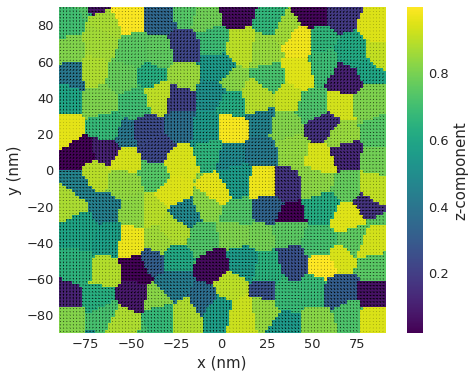

In [15]:
u.plane('z').mpl()

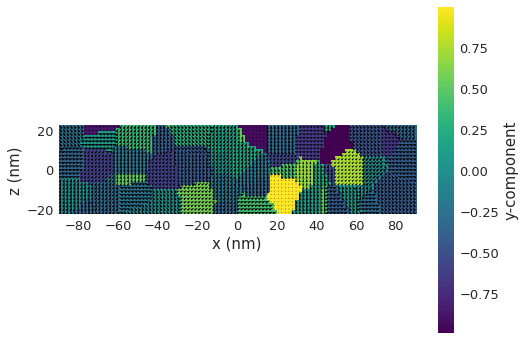

In [62]:
u.plane('y').mpl()

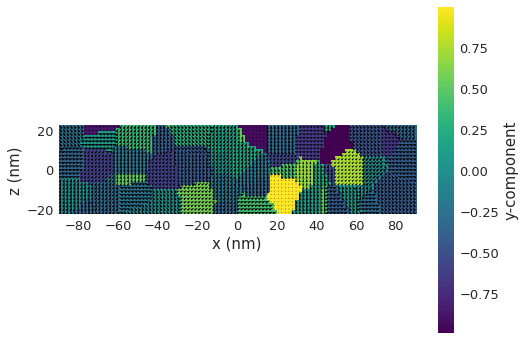

In [63]:
u.plane('y').mpl()

In [16]:
system = mm.System(name='try45')
B1_array = np.arange(1.5, -1.2, -0.08)

gamma0 = 0  # gyromagnetic ratio (m/As)
alpha = 0.3  # Gilbert damping
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)


system.energy = mm.Exchange(A=A) +  mm.UniaxialAnisotropy(K=K, u=u) + mm.Demag()+mm.Zeeman(H=(0, 0, 0))
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms)

In [ ]:
md = mc.MinDriver()
md.drive(system, overwrite=True)

evolve = mc.CGEvolver()
md = mc.MinDriver(stopping_mxHxm=0.01)

mz = []
S1 = []
S2 = []
S3 = []
S4 = []
S5 = []
S6 = []

for B in B1_array:
    system.energy.zeeman.H = (0, 0,B/mm.consts.mu0)
    md.drive(system)
    mz.append(system.m.orientation.z.average)
    m1 = system.m.orientation.plane(z=22e-9)
    m2 = system.m.orientation.plane(z=12e-9)
    m3 = system.m.orientation.plane(z=0e-9)
    m4 = system.m.orientation.plane(z=-22e-9)
    m5 = system.m.orientation.plane(z=-11e-9)
    S1.append((m1 @ (m1.derivative('x') & m1.derivative('y'))).surface_integral / (4*math.pi))
    S2.append((m2 @ (m2.derivative('x') & m2.derivative('y'))).surface_integral / (4*math.pi))
    S3.append((m3 @ (m3.derivative('x') & m3.derivative('y'))).surface_integral / (4*math.pi))
    S4.append((m4 @ (m4.derivative('x') & m4.derivative('y'))).surface_integral / (4*math.pi))
    S5.append((m5 @ (m5.derivative('x') & m5.derivative('y'))).surface_integral / (4*math.pi))

Running OOMMF (TclOOMMFRunner) [2022/09/01 18:23]... (327.3 s)
Running OOMMF (TclOOMMFRunner) [2022/09/01 18:31]... (92.3 s)
Running OOMMF (TclOOMMFRunner) [2022/09/01 18:35]... (19.0 s)
Running OOMMF (TclOOMMFRunner) [2022/09/01 18:38]... (21.8 s)
Running OOMMF (TclOOMMFRunner) [2022/09/01 18:40]... (29.4 s)
Running OOMMF (TclOOMMFRunner) [2022/09/01 18:43]... (51.7 s)
Running OOMMF (TclOOMMFRunner) [2022/09/01 18:47]... (21.3 s)
Running OOMMF (TclOOMMFRunner) [2022/09/01 18:49]... (24.0 s)
Running OOMMF (TclOOMMFRunner) [2022/09/01 18:52]... (51.8 s)
Running OOMMF (TclOOMMFRunner) [2022/09/01 18:56]... 

In [23]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,mz, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz/Ms', fontsize=20)
plt.legend()
plt.show()

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,S1, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Skyrmion number Q', fontsize=20)
plt.legend()
plt.show()

import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,mz, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz/Ms', fontsize=20)
plt.legend()
plt.show()
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,S2, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Skyrmion number Q', fontsize=20)
plt.legend()
plt.show()

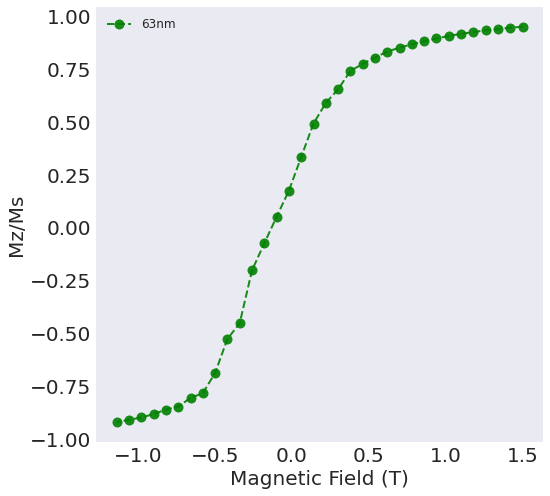

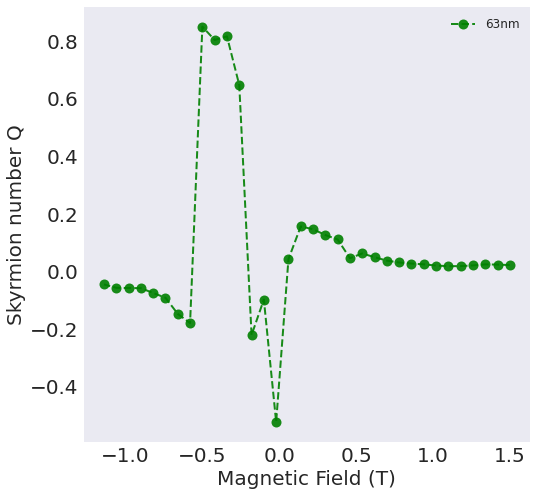

In [25]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,mz, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz/Ms', fontsize=20)
plt.legend()
plt.show()

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,S3, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Skyrmion number Q', fontsize=20)
plt.legend()
plt.show()

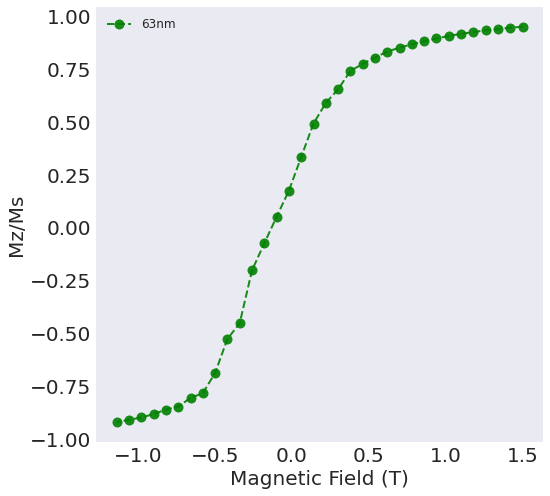

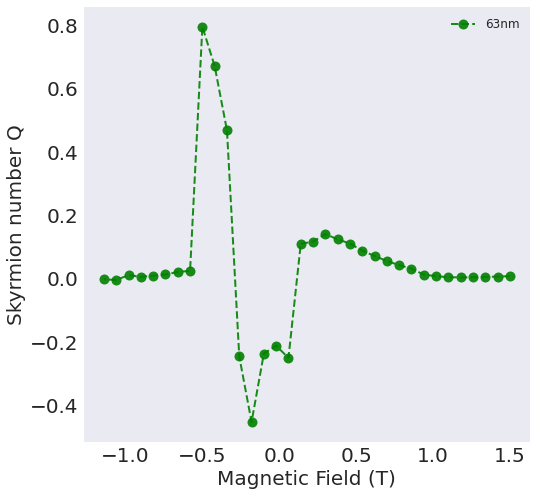

In [26]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,mz, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz/Ms', fontsize=20)
plt.legend()
plt.show()

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,S4, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Skyrmion number Q', fontsize=20)
plt.legend()
plt.show()

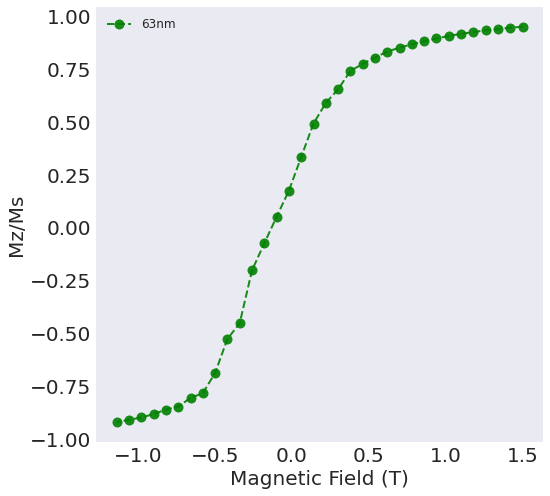

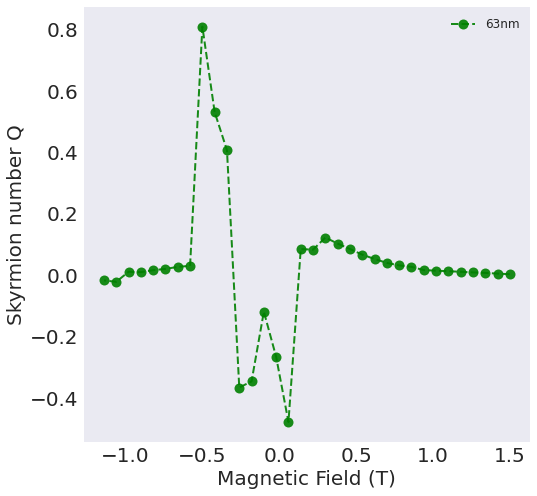

In [27]:
import matplotlib.pyplot as plt
Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,mz, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Mz/Ms', fontsize=20)
plt.legend()
plt.show()

Fig=plt.figure(figsize=(8, 8))
ax1=Fig.add_subplot(1, 1, 1)
ax1.plot(B1_array,S5, 'go', linestyle='--',linewidth=2, markersize=10, alpha=0.9, label='63nm')
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Magnetic Field (T)', fontsize=20)
plt.ylabel('Skyrmion number Q', fontsize=20)
plt.legend()
plt.show()

In [22]:
import micromagneticdata as md
data = md.Data(system.name)
@df.interact()
def interactive_plot(n=data.selector()):
    data.drive(n).step(0).plane(z=21e-9).mpl()
    data.drive(n).step(0).plane(z=-15e-9).mpl()
    data.drive(n).step(0).plane(z=-18e-9).mpl()
    data.drive(n).step(0).plane(z=-11e-9).mpl()

interactive(children=(BoundedIntText(value=0, description='drive', max=35), Output()), _dom_classes=('widget-i…

In [28]:
print(S1)
print(S2)
print(S3)
print(S4)
print(S5)
print(mz)

[0.040584800918382576, 0.0440266172642465, 0.047617172665043735, 0.051376188702682936, 0.05570168335945551, 0.06041959050651985, 0.06570974532539886, 0.07238629513055238, 0.07879463220567216, 0.08269961239167133, 0.08915790148713018, 0.09535255285437155, 0.10156291034090727, 0.11560980681982908, 0.12248614443467101, 0.12594899974096424, 0.14272121222155765, 0.09338377521850301, -0.8592107322430445, -0.23596091691904011, -0.28024401263578763, 0.6625688530741406, 0.9398600221032303, 0.8613919651367907, 0.8911090042965774, 0.8013033990189828, -0.13447545087586443, -0.12340330800628654, -0.11416454426003189, -0.09599720291956823, -0.08481398203986708, -0.06950547690160941, -0.06372538716356092, -0.05838373498201357]
[0.01216087347132704, 0.013015540424893415, 0.012757138405416792, 0.010853671268451624, 0.009146714743240648, 0.007679761645751421, 0.006474751892492679, 0.005860493454456269, 0.004822301285129301, 0.002036494789153208, -0.0002509253754501818, -0.004334079167666414, -0.00852123

In [77]:
S3[19]

-0.5259114688091315

In [29]:
B1_array.tolist()

[1.5,
 1.42,
 1.3399999999999999,
 1.2599999999999998,
 1.1799999999999997,
 1.0999999999999996,
 1.0199999999999996,
 0.9399999999999995,
 0.8599999999999994,
 0.7799999999999994,
 0.6999999999999993,
 0.6199999999999992,
 0.5399999999999991,
 0.4599999999999991,
 0.379999999999999,
 0.29999999999999893,
 0.21999999999999886,
 0.1399999999999988,
 0.05999999999999872,
 -0.02000000000000135,
 -0.10000000000000142,
 -0.1800000000000015,
 -0.26000000000000156,
 -0.34000000000000163,
 -0.4200000000000017,
 -0.5000000000000018,
 -0.5800000000000018,
 -0.6600000000000019,
 -0.740000000000002,
 -0.8200000000000021,
 -0.9000000000000021,
 -0.9800000000000022,
 -1.0600000000000023,
 -1.1400000000000023]